In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir_ = Path('/content/drive/MyDrive/Final/')
filepaths = list(dir_.glob(r'**/*.png'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)

In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 12716

Number of different labels: 3

Labels: ['desk' 'chair' 'tv']


<ipython-input-5-9c442b3eebff>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


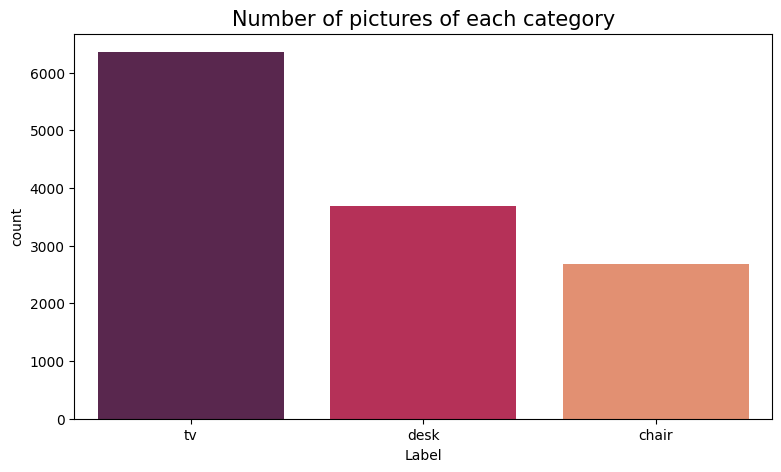

In [ ]:
#Label Category 분포 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
# Training/test split
# train_df,test_df = train_test_split(df.sample(frac=0.2), test_size=0.1,random_state=0) #모델링 시간이 오래걸리면 사용
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((11444, 2), (1272, 2))

In [ ]:
#모델 전처리
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./224,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/Final/',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/Final/',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 10174 images belonging to 3 classes.
Found 2542 images belonging to 3 classes.


In [ ]:
#데이터 증강(Data Augmentation)으로 이미지 로드
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
#전이학습을 사용해서 모델 성능 높이기function ClickConnect(){

models = {"DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0}}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dense도 8로 설정#클래스 개수 여기에 있음!!!
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습#epoch 여기에 있음!!!!
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 10300 validated image filenames belonging to 3 classes.
Found 1144 validated image filenames belonging to 3 classes.
Found 1272 validated image filenames belonging to 3 classes.


74836368/74836368 [==============================] - 5s 0us/step


In [ ]:
#텐서플로우 라이트로 변환!!!!
converter = tf.lite.TFLiteConverter.from_keras_model(m)
tflite_model = converter.convert()

In [ ]:
#변환 파일 저장!!!
open('/content/drive/MyDrive/Final_1_converted_model.tflite', 'wb').write(tflite_model)

In [ ]:
#텐서플로우 라이트로 변환!!!!
converter = tf.lite.TFLiteConverter.from_keras_model(history)
tflite_model = converter.convert()
#변환 파일 저장!!!
open('/content/drive/MyDrive/Final_2_converted_model.tflite', 'wb').write(tflite_model)

In [ ]:


#Test 데이터로 성능 확인
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

In [ ]:
#정확도 시각화
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
#텐서플로우 라이트로 변환!!!!
converter = tf.lite.TFLiteConverter.from_keras_model(history)
tflite_model = converter.convert()
#변환 파일 저장!!!
open('/content/drive/MyDrive/Final_2_converted_model.tflite', 'wb').write(tflite_model)# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

In [ ]:
#여러 이미지 예측
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()